# DNN: analysis with Keras of 2D data

In [1]:
import numpy as np
import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop, SGD

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 13

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

%run useful.py


perc_train = 0.8


## Read data

(2000, 8)
8
[1.83918812 2.04560279 5.67725029 5.95544703 9.6451452  6.53177097
 7.48906638 6.53569871] 1
[7.47714809 9.61306736 0.08388298 1.06444377 2.98703714 6.56411183
 8.09812553 8.72175914] 0
[9.64647597 7.23685347 6.42475328 7.17453621 4.67599007 3.25584678
 4.39644606 7.29689083] 0
[9.94014586 6.76873712 7.90822518 1.70914258 0.26849276 8.00370244
 9.03722538 0.2467621 ] 0
[4.91747318 5.26255167 5.9636601  0.51957545 8.95089528 7.2826618
 8.18350011 5.00222753] 1
data: 2000
train: 1600


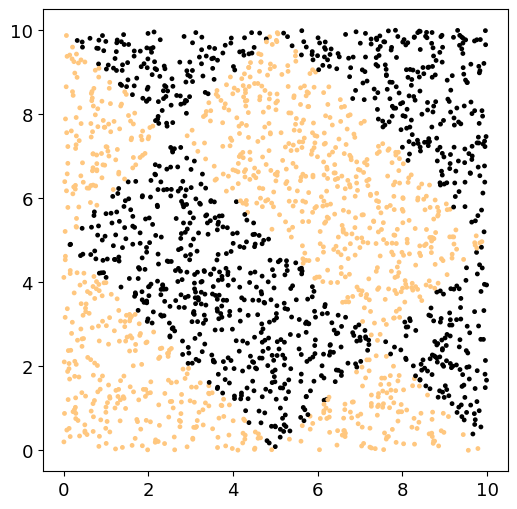

In [2]:
TYPE=3

L=8

B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)

x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)


L = len(x[0])
print(L)

for i in range(5):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)


## Standardize data

In [3]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)

def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss

x = Standardize(x,x_mean,x_std)

print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))


before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split training and test data

In [4]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))


Train: 1600 	 Validation: 400


## Define the model with Keras / Tensorflow

In [7]:
import tensorflow as tf

def build_model(hp):
    model = Sequential()
    model.add(Dense(L, input_shape=(L,), activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu'])))
    for _ in range(3):
        model.add(Dense(20, activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu'])))
        model.add(Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2])))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


## Perform Random Search Using Keras Tuner

In [8]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  
    executions_per_trial=1,
    directory='tuner_results',
    project_name='dnn_random_search'
)

tuner.search(x_train, y_train, epochs=100, batch_size=50, validation_data=(x_valid, y_valid), verbose=2)


best_hps = tuner.get_best_hyperparameters(num_trials=3)
for i, hp in enumerate(best_hps):
    print(f"Best model {i+1}: Optimizer={hp.get('optimizer')}, Learning Rate={hp.get('learning_rate')}, Activation={hp.get('activation')}, Dropout={hp.get('dropout')}")


Trial 20 Complete [00h 00m 16s]
val_accuracy: 0.5575000047683716

Best val_accuracy So Far: 0.9674999713897705
Total elapsed time: 00h 05m 23s
Best model 1: Optimizer=adam, Learning Rate=0.01, Activation=elu, Dropout=0.0
Best model 2: Optimizer=adam, Learning Rate=0.001, Activation=elu, Dropout=0.1
Best model 3: Optimizer=rmsprop, Learning Rate=0.001, Activation=relu, Dropout=0.2


## K-Fold Cross Validation on Best Hyperparameters

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_hp = best_hps[0]  

accuracies = []
for train_idx, val_idx in kf.split(x):
    x_train_k, x_val_k = x[train_idx], x[val_idx]
    y_train_k, y_val_k = y[train_idx], y[val_idx]

    model = build_model(best_hp)
    history = model.fit(x_train_k, y_train_k, epochs=100, batch_size=50, validation_data=(x_val_k, y_val_k), verbose=0)
    
    val_acc = history.history['val_accuracy'][-1]
    accuracies.append(val_acc)

print(f"K-Fold Validation Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


K-Fold Validation Accuracy: 0.9445 ± 0.0219


In [10]:
final_model = build_model(best_hp)
history = final_model.fit(x_train, y_train, epochs=400, batch_size=50, validation_data=(x_valid, y_valid), verbose=2)


Epoch 1/400
32/32 - 1s - loss: 0.7079 - accuracy: 0.5038 - val_loss: 0.6886 - val_accuracy: 0.5550 - 848ms/epoch - 26ms/step
Epoch 2/400
32/32 - 0s - loss: 0.6918 - accuracy: 0.5269 - val_loss: 0.6909 - val_accuracy: 0.5325 - 103ms/epoch - 3ms/step
Epoch 3/400
32/32 - 0s - loss: 0.6884 - accuracy: 0.5337 - val_loss: 0.6898 - val_accuracy: 0.5375 - 98ms/epoch - 3ms/step
Epoch 4/400
32/32 - 0s - loss: 0.6870 - accuracy: 0.5312 - val_loss: 0.6754 - val_accuracy: 0.5400 - 97ms/epoch - 3ms/step
Epoch 5/400
32/32 - 0s - loss: 0.6837 - accuracy: 0.5362 - val_loss: 0.6684 - val_accuracy: 0.5850 - 96ms/epoch - 3ms/step
Epoch 6/400
32/32 - 0s - loss: 0.6821 - accuracy: 0.5281 - val_loss: 0.6677 - val_accuracy: 0.5975 - 99ms/epoch - 3ms/step
Epoch 7/400
32/32 - 0s - loss: 0.6643 - accuracy: 0.5888 - val_loss: 0.6358 - val_accuracy: 0.6300 - 94ms/epoch - 3ms/step
Epoch 8/400
32/32 - 0s - loss: 0.6279 - accuracy: 0.6344 - val_loss: 0.5989 - val_accuracy: 0.6775 - 98ms/epoch - 3ms/step
Epoch 9/400
3

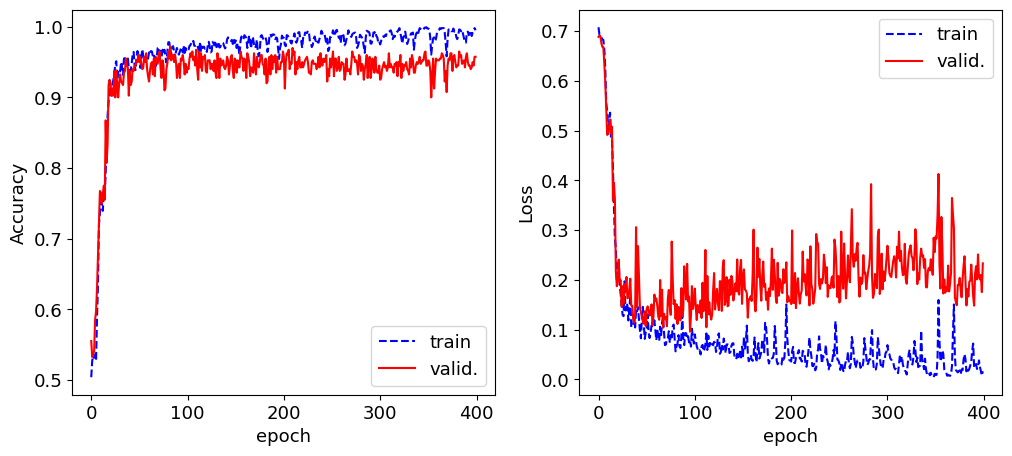

In [11]:
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]
ax.plot(history.history['accuracy'],label="train",c="b",ls="--")
ax.plot(history.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(history.history['loss'],label="train",c="b",ls="--")
ax.plot(history.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()


## Grid to show preditions

319/319 [==============================] - 1s 1ms/step


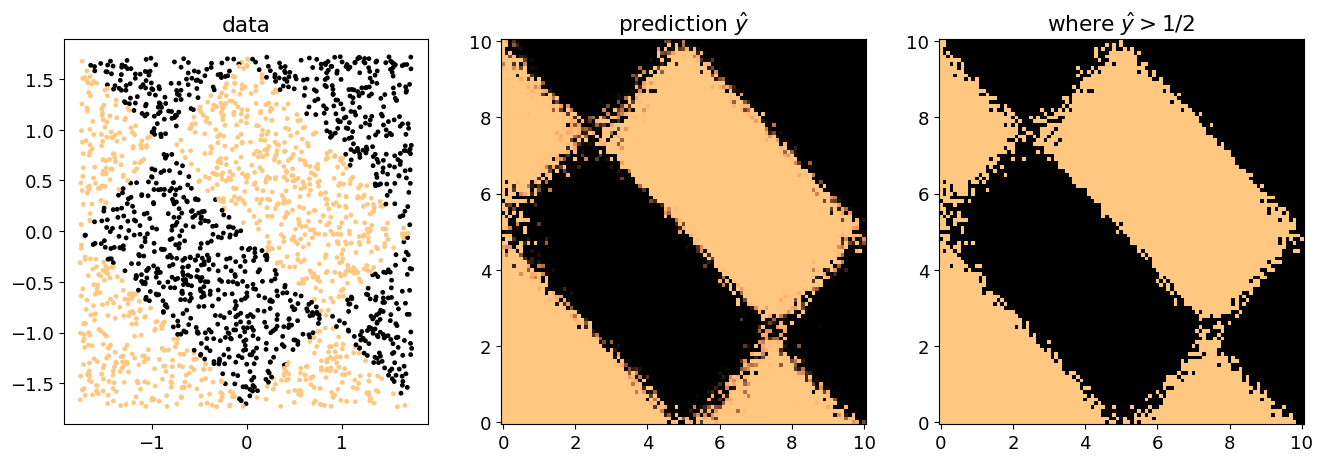

Remember: these are 2 out of L=8 dimensions, of which L-2 contain random noise


In [12]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = final_model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")

ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")

ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()

print(f"Remember: these are 2 out of L={L} dimensions, of which L-2 contain random noise")


In [21]:
sample_ratios = [0.2, 0.4, 0.6, 0.95]
eval_results = []

for ratio in sample_ratios:
    
    train_size = int(len(x_train) * ratio)
    x_sub_train, y_sub_train = x_train[:train_size], y_train[:train_size]

    temp_model = build_model(best_hp)  
    temp_model.fit(x_sub_train, y_sub_train, 
                   epochs=300, 
                   validation_data=(x_valid, y_valid),
                   verbose=0)
    
    loss, accuracy = temp_model.evaluate(x_valid, y_valid, verbose=0)

    eval_results.append((ratio, accuracy))

for ratio, acc in eval_results:
    print(f"Data fraction {ratio:.1f}: Validation Accuracy = {acc:.4f}")


Data fraction 0.2: Validation Accuracy = 0.7425
Data fraction 0.4: Validation Accuracy = 0.8700
Data fraction 0.6: Validation Accuracy = 0.9275
Data fraction 0.9: Validation Accuracy = 0.9100


In [22]:
def add_noise_to_data(data, noise_level=0.01):
    noisy_data = data + noise_level * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return noisy_data

augmentation_factors = [0.0, 0.3, 0.5, 1.0]
noise_level = 0.01  

augmentation_results = []

for factor in augmentation_factors:
    num_samples = len(x_train)
    new_samples = int(num_samples * factor)
    
    random_indices = np.random.choice(range(num_samples), size=new_samples, replace=True)
    
    noisy_train_data = add_noise_to_data(x_train[random_indices], noise_level=noise_level)
    noisy_train_labels = y_train[random_indices] 
    
    x_train_combined = np.concatenate([x_train, noisy_train_data], axis=0)
    y_train_combined = np.concatenate([y_train, noisy_train_labels], axis=0)
   
    model_with_augmentation = build_model(best_hp)

    model_with_augmentation.fit(
        x_train_combined, 
        y_train_combined, 
        epochs=300,       
        batch_size=32,
        validation_data=(x_valid, y_valid),
        verbose=0
    )
    
    validation_loss, validation_accuracy = model_with_augmentation.evaluate(x_valid, y_valid, verbose=0)
    augmentation_results.append((factor, validation_accuracy))

print("Data Augmentation Results:")
for factor, accuracy in augmentation_results:
    print(f"Augmentation factor = {factor:.2f} --> Validation Accuracy = {accuracy:.4f}")



Data Augmentation Results:
Augmentation factor = 0.00 --> Validation Accuracy = 0.9300
Augmentation factor = 0.30 --> Validation Accuracy = 0.9250
Augmentation factor = 0.50 --> Validation Accuracy = 0.9350
Augmentation factor = 1.00 --> Validation Accuracy = 0.9250
